In [1]:
import sys
import sklearn
if sys.version_info[0] < 3:
	raise Exception("Python 3 not detected.")
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from scipy import io

if __name__ == "__main__":
    mnist_data = np.load(f"Desktop/Berkeley/Junior/CS 189/HWs/hw1/data/mnist-data.npz")
    spam_data = np.load(f"Desktop/Berkeley/Junior/CS 189/HWs/hw1/data/spam-data.npz")
    cifar10_data = np.load(f"Desktop/Berkeley/Junior/CS 189/HWs/hw1/data/cifar10-data.npz")

In [2]:
# Q2 Data Partitioning
# To shuffle two ndarrays in unison, I took inspiration from: 
# https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison

def shuffle_split(full_data, labels, val_data_size):
    size = len(full_data)
    assert size == len(labels)
    assert val_data_size >= 0
    if val_data_size < 1.0:
        val_data_size = int(val_data_size * size)
    permute = np.random.permutation(size)
    train_data_size = size - val_data_size
    train_data, train_labels = full_data[permute][:train_data_size], labels[permute][:train_data_size]
    val_data, val_labels = full_data[permute][train_data_size:], labels[permute][train_data_size:]
    return train_data, train_labels, val_data, val_labels

mnist_train_data, mnist_train_labels, mnist_val_data, mnist_val_labels = ( 
    shuffle_split(mnist_data['training_data'], mnist_data['training_labels'], 10000))

spam_train_data, spam_train_labels, spam_val_data, spam_val_labels = ( 
    shuffle_split(spam_data['training_data'], spam_data['training_labels'], 0.2))
    
cifar10_train_data, cifar10_train_labels, cifar10_val_data, cifar10_val_labels = ( 
    shuffle_split(cifar10_data['training_data'], cifar10_data['training_labels'], 5000))

In [3]:
# Q3 Support Vector Machines
# Func for plotting the results

def plotting_accuracy(training_examples, training_scores, val_scores, title):
    plt.figure()
    plt.xlabel("# Examples")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.plot(training_examples, training_scores, label="Training Set")
    plt.plot(training_examples, val_scores, label="Validation Set")
    plt.legend()
    plt.show()  

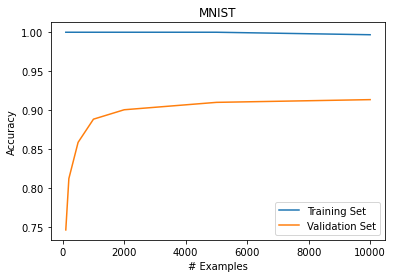

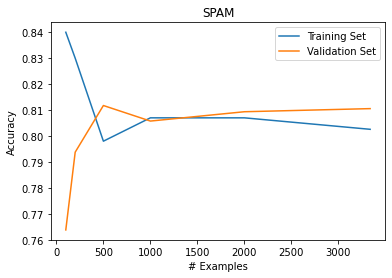

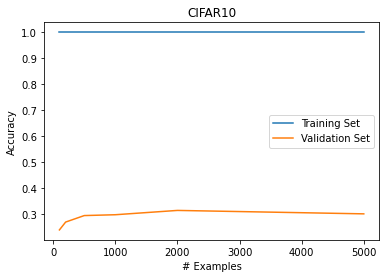

In [4]:
# Q3 Support Vector Machines

mnist_training_examples = [100, 200, 500, 1000, 2000, 5000, 10000]
spam_training_examples = [100, 200, 500, 1000, 2000, len(spam_train_data)]
cifar10_training_examples = [100, 200, 500, 1000, 2000, 5000]

svm_model = svm.SVC(kernel='linear', random_state=42)

mnist_train_data = mnist_train_data.reshape(50000, 784)
mnist_val_data = mnist_val_data.reshape(10000, 784)
train_scores, val_scores = [], []
for example in mnist_training_examples:
    train_data, train_labels = mnist_train_data[:example], mnist_train_labels[:example]
    svm_model.fit(train_data, train_labels)
    train_pred = svm_model.predict(train_data)
    train_scores.append(sklearn.metrics.accuracy_score(train_labels, train_pred))
    val_pred = svm_model.predict(mnist_val_data)
    val_scores.append(sklearn.metrics.accuracy_score(mnist_val_labels, val_pred))
plotting_accuracy(mnist_training_examples, train_scores, val_scores, "MNIST")

train_scores, val_scores = [], []
for example in spam_training_examples:
    train_data, train_labels = spam_train_data[:example], spam_train_labels[:example]
    svm_model.fit(train_data, train_labels)
    train_pred = svm_model.predict(train_data)
    train_scores.append(sklearn.metrics.accuracy_score(train_labels, train_pred))
    val_pred = svm_model.predict(spam_val_data)
    val_scores.append(sklearn.metrics.accuracy_score(spam_val_labels, val_pred))
plotting_accuracy(spam_training_examples, train_scores, val_scores, "SPAM")

train_scores, val_scores = [], []
for example in cifar10_training_examples:
    train_data, train_labels = cifar10_train_data[:example], cifar10_train_labels[:example]
    svm_model.fit(train_data, train_labels)
    train_pred = svm_model.predict(train_data)
    train_scores.append(sklearn.metrics.accuracy_score(train_labels, train_pred))
    val_pred = svm_model.predict(cifar10_val_data)
    val_scores.append(sklearn.metrics.accuracy_score(cifar10_val_labels, val_pred))
plotting_accuracy(cifar10_training_examples, train_scores, val_scores, "CIFAR10")


In [5]:
# Q4 Hyperparameter Tuning

def train_SVM(train_data, train_labels, C):
    svm_model = svm.SVC(kernel="linear", C=C, random_state=42)
    svm_model.fit(train_data, train_labels)
    return svm_model

size = 10000
C_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
results = []
for val in C_range:
    svm_model = train_SVM(mnist_train_data[:size], mnist_train_labels[:size], val)
    pred = svm_model.predict(mnist_val_data)
    score = sklearn.metrics.accuracy_score(mnist_val_labels, pred)
    results.append((val, score))
opt_c = max(results, key=lambda x: x[1])
print(opt_c)

(0.1, 0.93)


In [6]:
results

[(0.0001, 0.7769),
 (0.001, 0.898),
 (0.01, 0.9268),
 (0.1, 0.93),
 (1.0, 0.9134),
 (10.0, 0.9073),
 (100.0, 0.9073),
 (1000.0, 0.9073),
 (10000.0, 0.9073)]

In [7]:
# Q5 K-Fold Cross Validation
# K = 5
# To join two np arrays I referenced: https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html

results = []
C_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
size = len(spam_data['training_data'])
permute = np.random.permutation(size)
part_size = size // 5
spam_train_permute = spam_data['training_data'][permute]
spam_labels_permute = spam_data['training_labels'][permute]
for val in C_range:
    val_scores = []
    for i in range(0, 5):
        spam_val_data = spam_train_permute[i*part_size:(i+1)*part_size]
        spam_val_labels = spam_labels_permute[i*part_size:(i+1)*part_size]
        spam_train_data = np.concatenate((spam_train_permute[:i*part_size], 
                                         spam_train_permute[(i+1)*part_size:]), axis=0)
        spam_train_labels = np.concatenate((spam_labels_permute[:i*part_size], 
                                          spam_labels_permute[(i+1)*part_size:]), axis=0)
        svm_model = train_SVM(spam_train_data, spam_train_labels, val)
        pred = svm_model.predict(spam_val_data)
        val_scores.append(sklearn.metrics.accuracy_score(spam_val_labels, pred))
    results.append((val, np.mean(val_scores)))
opt_c = max(results, key=lambda x: x[1])
print(opt_c)

(10.0, 0.8023980815347722)


In [8]:
results

[(1e-05, 0.7088729016786571),
 (0.0001, 0.7146282973621103),
 (0.001, 0.7470023980815348),
 (0.01, 0.7788968824940048),
 (0.1, 0.7961630695443644),
 (1.0, 0.8007194244604318),
 (10.0, 0.8023980815347722),
 (100.0, 0.8023980815347722)]

In [9]:
# Q6 Kaggle
import csv

# For MNIST dataset
with open('mnistdata_csv', mode='w') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow(['Id', 'Category'])
    mnist_train_data = mnist_data['training_data'].reshape(60000, 784)
    svm_model = svm.SVC(kernel="linear", C=0.1, random_state=42)
    svm_model.fit(mnist_train_data, mnist_data['training_labels'])
    pred = svm_model.predict(mnist_data['test_data'].reshape(10000, 784))
    for idx, x in enumerate(pred):
        writer.writerow([idx+1, x])

In [10]:
# For SPAM dataset
with open('spam_testdata', mode='w') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow(['Id', 'Category'])
    spam_train_data = spam_data['training_data']
    svm_model = svm.SVC(kernel="rbf", C=1000, random_state=42)
    svm_model.fit(spam_train_data, spam_data['training_labels'])
    pred = svm_model.predict(spam_data['test_data'])
    for idx, x in enumerate(pred):
        writer.writerow([idx+1, x])

In [11]:
# For cifar10 dataset
with open('cifar10_testdata', mode='w') as file:
    size = len(cifar10_data['training_data'])
    writer = csv.writer(file, delimiter=',')
    writer.writerow(['Id', 'Category'])
    permute = np.random.permutation(size)
    cifar10_train_data = cifar10_data['training_data'][permute][:2000]
    svm_model = svm.SVC(kernel="linear", C=1.0, verbose=True, random_state=42)
    svm_model.fit(cifar10_train_data, cifar10_data['training_labels'][permute][:2000])
    pred = svm_model.predict(cifar10_data['test_data'])
    for idx, x in enumerate(pred):
        writer.writerow([idx+1, x])

[LibSVM]